**Import libraries**

In [264]:
import numpy as np
from numpy import *
import scipy.linalg
import scipy.stats
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt
import random

### Load in the data
#### We have 4 mackey glass time series datasets we can use, each with a different delay value (tau = 5, 17, 30 and 50)
#### See http://www.scholarpedia.org/article/Mackey-Glass_equation for more information on Mackey Glass

Can download from [here](https://mega.nz/folder/TJMhQYBa#cvh1P4bM4w2hrPeDmVDiaQ)

In [265]:
data = dict(mg_5 = loadtxt('mackey_glass_5.txt'),
            mg_17 = loadtxt('mackey_glass_17.txt'),
            mg_30 = loadtxt('mackey_glass_30.txt'),
            mg_50 = loadtxt('mackey_glass_50.txt'))

### Visualize your data

In [266]:
x_vals = arange(1000)
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_vals, y=data['mg_5'][0:1000],
                         name='tau = 5'))
fig.add_trace(go.Scatter(x=x_vals, y=data['mg_17'][0:1000],
                         name='tau = 17'))
fig.add_trace(go.Scatter(x=x_vals, y=data['mg_30'][0:1000],
                         name='tau = 30'))
fig.add_trace(go.Scatter(x=x_vals, y=data['mg_50'][0:1000],
                         name='tau = 50'))

fig.update_layout(title='Mackey Glass time series datasets with a range of delays (tau)',
                   xaxis_title='time',
                   yaxis_title='Target value')


fig.show()


### Specify length of your testing and training sets, and set your target data

In [267]:
# Which dataset do we want to use
mg_choice = 'mg_17'

# length of training dataset
train_len = 2000
# length of testing dataset
test_len = 2000

offset_val = 1 #for now, our target is simply going to be the next point in the time series

#number of input and output features in each time step
#since the input and target are both vectors, that means the dimensions of our input and output are 1
n_inputs = 1
n_outputs = 1

In [268]:
#input weights and reservoir connections/recurrent weights are generated from Uniform(-input_scale, input_scale)
#these weight matrices are non-sparse....which means the reservoir is essentially fully connected.
input_scale = 0.5    #scaling of [-1, 1] to [-0.5, 0.5]
n_neurons = 200
rho = 0.95
alpha = 0.5    # leak rate

### Echo State Network

In [269]:
class EchoStateNetwork:
    def __init__(self, n_neurons, n_inputs, input_scale, alpha,  esn_no, beta=1e-8):
        """
        Initialize the Echo State Network with the given parameters.

        :param n_neurons: Number of reservoir neurons
        :param n_inputs: Number of input features
        :param input_scale: Scale for generating initial weights
        :param alpha: Leak rate
        :param esn_no: if it is connected only to input then 1 (not connected to multple encoder)
        :param beta: Regularization coefficient for ridge regression
        """
        self.n_neurons = n_neurons
        self.n_inputs = n_inputs
        self.input_scale = input_scale
        self.alpha = alpha
        self.beta = beta
        self.esn_no = esn_no
        self.W_in, self.W = self.generate_weights()

    def set_spectral_radius(self, rho_W):
        """
        Set the spectral radius of the weight matrix W.
        """
        # print('Computing spectral radius...')
        initial_rho_W = max(abs(linalg.eig(self.W)[0]))      # calculate the max eigen value
        # print(f"Original spectral radius: {initial_rho_W}")
        self.W *= rho_W / initial_rho_W                      # update spectral radius
        # print(f"Spectral radius set to: {max(abs(linalg.eig(self.W)[0]))}")

    def generate_weights(self):
        """
        Generate input weights (W_in) and reservoir weights (W).
        """
        W_in = np.random.uniform(low=-self.input_scale, high=self.input_scale, size=self.n_neurons * (1 + self.n_inputs))  # added bias as 1
        W_in = W_in.reshape((self.n_neurons, self.n_inputs + 1))
        W = np.random.uniform(low=-self.input_scale, high=self.input_scale, size=self.n_neurons * self.n_neurons)
        W = W.reshape(self.n_neurons, self.n_neurons)
        return W_in, W

    def create_target(self, dta, target_offset):
        """
        Create a target vector by shifting the data by a specified offset.
        """
        return dta[None, target_offset:len(dta)]

    def neuron_activations(self, train_len, dta):
      """
      Run the training data through the reservoir and collect the activation states.
      """
      X = np.zeros((1 + self.n_neurons, train_len))  # taken bias term
      x = np.zeros((self.n_neurons, 1))
      for t in range(train_len):
          u = dta[t].reshape(-1, 1)  # Ensure u is a column vector
          if self.esn_no == 1:       # check it is connected to input or not
              bias_u = np.vstack((np.array([[1]]), u))
              # if solely connected to input so need to add bias
              x = (1 - self.alpha) * x + self.alpha * np.tanh(np.dot(self.W_in, bias_u) + np.dot(self.W, x))
          else:
              # if already connected to another encoder(s) so bias term is already taken care in activation matrix no need add again
              x = (1 - self.alpha) * x + self.alpha * np.tanh(np.dot(self.W_in, u) + np.dot(self.W, x))

          # Ensure shapes align for vstack
          X[:, t] = np.vstack((np.array([[1]]), x))[:, 0]

      return X


    def train_output_weights(self, Y_target, X, train_len):
        """
        Train the output weights using ridge regression.
        """
        Y_target = Y_target[:, 0:train_len]
        X_T = X.T
        W_out = dot(dot(Y_target, X_T), linalg.inv(dot(X, X_T) + self.beta * eye(1 + self.n_neurons))) # defining output weight matrix
        return W_out

    def test(self, X, dta, W_out, train_len, test_len, prev_ESN_state, mode):
        """
        Test the trained ESN using either generative or forward mode.
        """
        x = X[(1):(1 + self.n_neurons), -1].reshape((self.n_neurons, 1))
        X_future = np.zeros((1 + self.n_neurons, test_len)) #store future state of ESN which can be used in next connecting encoder

        if self.esn_no == 1:  #soley connented to inputs
          u = dta[train_len]  # taken input from dataset
          Y = zeros((W_out.shape[0], test_len))  # testing result

          for t in range(test_len):
            u = u.reshape(-1, 1)  # Ensure u is a column vector
            bias_u = np.vstack((np.array([[1]]), u))  # Add bias term
            x = (1 - self.alpha) * x + self.alpha * np.tanh(np.dot(self.W_in, bias_u) + np.dot(self.W, x))
            y = dot(W_out, np.vstack((np.array([[1]]), x)))
            Y[:, t] = y
            X_future[:, t] = np.vstack((np.array([[1]]), x))[:, 0] #store future activation of this encoder
            u = y if mode == "generative" else dta[train_len + t + 1]

        else:
          u = prev_ESN_state[0] #taken input from future state of previously connected encoder
          Y = zeros((W_out.shape[0], test_len))

          for t in range(test_len):
            u = u.reshape(-1, 1)  # Ensure u is a column vector
            x = (1 - self.alpha) * x + self.alpha * np.tanh(np.dot(self.W_in, u) + np.dot(self.W, x))
            y = dot(W_out, np.vstack((np.array([[1]]), x)))
            Y[:, t] = y
            X_future[:, t] = np.vstack((np.array([[1]]), x))[:, 0]
            if mode == "generative":
               u = X_future[:, t].T
            elif mode == 'forward' and t != test_len-1 :
               u = prev_ESN_state[t + 1]

        return Y, X_future




In [270]:
def mse(Y, Y_target):
    """
    Compute the mean squared error between predictions and target.
    """
    X = np.sum(np.square(Y_target - Y[0, :]))
    return ((X) / (Y.shape[1])).item()

### Lets try on single ESN

In [271]:
ESN1 = EchoStateNetwork(n_neurons, n_inputs, input_scale, alpha,1, beta=1e-8) # initialise
W_in, W = ESN1.generate_weights() #Generate the input and recurrent weights
print("Size of input weights",W_in.shape)
print("Size of res weights",W.shape)

W = ESN1.set_spectral_radius(rho) #Scale the spectral radius

Y_target = ESN1.create_target(data[mg_choice], offset_val) #Generate the target data wrt offset
print("shape of the target: ",Y_target.shape)

X = ESN1.neuron_activations(train_len, data[mg_choice]) #Map input data through reservoir and collect neuron activations
print("shape of resservoir_state", X.shape)

#ompute W_out using ridge regression with default beta value
W_out = ESN1.train_output_weights(Y_target,X, train_len)
print("shape of output_weights",W_out.shape)




Size of input weights (200, 2)
Size of res weights (200, 200)
shape of the target:  (1, 9999)
shape of resservoir_state (201, 2000)
shape of output_weights (1, 201)


In [272]:
Y_test,z= ESN1.test(X, data[mg_choice], W_out, train_len, test_len, None, mode = "generative")
print("Size of Y_test",Y_test.shape)
print("Size of future activation state",z.shape)

Size of Y_test (1, 2000)
Size of future activation state (201, 2000)


In [273]:
#if we want to only compute the error on a portion of the output, we can adjust the data we supply to the mse function
n_points_error = 499
x_lim = n_points_error + 1
print("MSE: ", mse(Y_test[:, 0:n_points_error], Y_target[0,train_len:train_len+n_points_error]))

MSE:  7.240236447592689e-05


In [274]:
#x_lim = 100
x_vals = arange(test_len)

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_vals, y=Y_test[0,0:x_lim],
                         name='test data'))
fig.add_trace(go.Scatter(x=x_vals, y=Y_target[0,train_len:train_len+x_lim],
                         name='target data'))

fig.update_layout(title='test output vs target output',
                   xaxis_title='time',
                   yaxis_title='Target value')


fig.show()


###Ensemble model

In [275]:
np.random.seed = 42 # make it little less random😅

#### Series

Start 3 encoder setup

In [276]:
ESN1 = EchoStateNetwork(200, 1, input_scale, alpha, 1, beta=1e-8)
ESN2 = EchoStateNetwork(200, 200, input_scale, alpha, 2, beta=1e-8) # 2nd encoder get input from the 1st
ESN3 = EchoStateNetwork(200, 200, input_scale, alpha, 3, beta=1e-8) # 3rd encoder get input from 2nd

In [277]:
W_in, W = ESN1.generate_weights()#Generate the input and recurrent weights
print("Size of input weights",W_in.shape)
print("Size of res weights",W.shape)
W = ESN1.set_spectral_radius(rho) #Scale the spectral radius

Y_target_1 = ESN1.create_target(data[mg_choice], offset_val) #Generate the target data wrt offset
print("shape of the target: ",Y_target.shape)

X_1 = ESN1.neuron_activations(train_len, data[mg_choice]) #Map input data through reservoir and collect neuron activations
print("shape of resservoir_state", X_1.shape)

#ompute W_out using ridge regression with default beta value
W_out_1 = ESN1.train_output_weights(Y_target_1,X_1, train_len)
print("shape of w_out", W_out.shape)

Size of input weights (200, 2)
Size of res weights (200, 200)
shape of the target:  (1, 9999)
shape of resservoir_state (201, 2000)
shape of w_out (1, 201)


In [278]:
W_in, W = ESN2.generate_weights()#Generate the input and recurrent weights
print("Size of input weights",W_in.shape)
print("Size of res weights",W.shape)
W = ESN2.set_spectral_radius(rho) #Scale the spectral radius

Y_target_2 = ESN2.create_target(data[mg_choice], offset_val) #Generate the target data wrt offset
print("shape of the target: ",Y_target.shape)

X_2 = ESN2.neuron_activations(train_len, X_1.T) #Map input data through reservoir and collect neuron activations
print("shape of resservoir_state", X_2.shape)

#ompute W_out using ridge regression with default beta value
W_out_2 = ESN2.train_output_weights(Y_target_2,X_2, train_len)
print("shape of w_out", W_out_2.shape)

Size of input weights (200, 201)
Size of res weights (200, 200)
shape of the target:  (1, 9999)
shape of resservoir_state (201, 2000)
shape of w_out (1, 201)


In [279]:
W_in, W = ESN3.generate_weights()#Generate the input and recurrent weights
print("Size of input weights",W_in.shape)
print("Size of res weights",W.shape)
W = ESN3.set_spectral_radius(rho) #Scale the spectral radius

Y_target_3 = ESN3.create_target(data[mg_choice], offset_val) #Generate the target data wrt offset
print("shape of the target: ",Y_target.shape)

X_3 = ESN3.neuron_activations(train_len, X_2.T) #Map input data through reservoir and collect neuron activations
print("shape of resservoir_state", X_3.shape)

#ompute W_out using ridge regression with default beta value
W_out_3 = ESN3.train_output_weights(Y_target_3,X_3, train_len)
print("shape of w_out", W_out_3.shape)

Size of input weights (200, 201)
Size of res weights (200, 200)
shape of the target:  (1, 9999)
shape of resservoir_state (201, 2000)
shape of w_out (1, 201)


In [280]:
Y_test_1, ESN1_futrue = ESN1.test(X_1, data[mg_choice], W_out_1, train_len, test_len, None, mode = "generative")
Y_test_2, ESN2_futrue = ESN2.test(X_2, data[mg_choice], W_out_2, train_len, test_len, ESN1_futrue.T, mode = "forward")
Y_test_3, ESN3_futrue = ESN1.test(X_3, data[mg_choice], W_out_3, train_len, test_len, ESN2_futrue.T, mode = "forward")

Y_test_net = (Y_test_1 + Y_test_2 + Y_test_1)/3 # take avg of all 3 encoder output

In [281]:
#if we want to only compute the error on a portion of the output, we can adjust the data we supply to the mse function
n_points_error = 499
x_lim = n_points_error + 1
print("MSE :",mse(Y_test_net[:, 0:n_points_error], Y_target_1[0,train_len:train_len+n_points_error]))

MSE : 3.3566516362239374e-05


In [282]:
#x_lim = 100
x_vals = arange(test_len)

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_vals, y=Y_test_net[0,0:x_lim],
                         name='test data'))
fig.add_trace(go.Scatter(x=x_vals, y=Y_target_1[0,train_len:train_len+x_lim],
                         name='target data'))

fig.update_layout(title='test output vs target output',
                   xaxis_title='time',
                   yaxis_title='Target value')


fig.show()


#### Parallel

In [283]:
# all encoder connected to input
ESN1 = EchoStateNetwork(200, 1, input_scale, alpha, 1, beta=1e-8)
ESN2 = EchoStateNetwork(200, 1, input_scale, alpha, 1, beta=1e-8)
ESN3 = EchoStateNetwork(200, 1, input_scale, alpha, 1, beta=1e-8)

In [284]:
W_in, W = ESN1.generate_weights()#Generate the input and recurrent weights
print("Size of input weights",W_in.shape)
print("Size of res weights",W.shape)
W = ESN1.set_spectral_radius(rho) #Scale the spectral radius

Y_target_1 = ESN1.create_target(data[mg_choice], offset_val) #Generate the target data wrt offset
print("shape of the target: ",Y_target.shape)

X_1 = ESN1.neuron_activations(train_len, data[mg_choice]) #Map input data through reservoir and collect neuron activations
print("shape of resservoir_state", X.shape)

#ompute W_out using ridge regression with default beta value
W_out_1 = ESN1.train_output_weights(Y_target_1,X_1, train_len)
print("shape of w_out", W_out_1.shape)

Size of input weights (200, 2)
Size of res weights (200, 200)
shape of the target:  (1, 9999)
shape of resservoir_state (201, 2000)
shape of w_out (1, 201)


In [285]:
W_in, W = ESN2.generate_weights()#Generate the input and recurrent weights
print("Size of input weights",W_in.shape)
print("Size of res weights",W.shape)
W = ESN2.set_spectral_radius(rho) #Scale the spectral radius

Y_target_2 = ESN2.create_target(data[mg_choice], offset_val) #Generate the target data wrt offset
print("shape of the target: ",Y_target.shape)

X_2 = ESN2.neuron_activations(train_len, data[mg_choice]) #Map input data through reservoir and collect neuron activations
print("shape of resservoir_state", X.shape)

#ompute W_out using ridge regression with default beta value
W_out_2 = ESN2.train_output_weights(Y_target_2,X_2, train_len)
print("shape of w_out", W_out_2.shape)

Size of input weights (200, 2)
Size of res weights (200, 200)
shape of the target:  (1, 9999)
shape of resservoir_state (201, 2000)
shape of w_out (1, 201)


In [286]:
W_in, W = ESN3.generate_weights()#Generate the input and recurrent weights
print("Size of input weights",W_in.shape)
print("Size of res weights",W.shape)
W = ESN3.set_spectral_radius(rho) #Scale the spectral radius

Y_target_3 = ESN3.create_target(data[mg_choice], offset_val) #Generate the target data wrt offset
print("shape of the target: ",Y_target.shape)

X_3 = ESN3.neuron_activations(train_len, data[mg_choice]) #Map input data through reservoir and collect neuron activations
print("shape of resservoir_state", X.shape)

#ompute W_out using ridge regression with default beta value
W_out_3 = ESN3.train_output_weights(Y_target_3,X_3, train_len)
print("shape of w_out", W_out_3.shape)

Size of input weights (200, 2)
Size of res weights (200, 200)
shape of the target:  (1, 9999)
shape of resservoir_state (201, 2000)
shape of w_out (1, 201)


In [287]:
Y_test_1, ESN1_futrue = ESN1.test(X_1, data[mg_choice], W_out_1, train_len, test_len, None, mode = "generative")
Y_test_2, ESN2_futrue = ESN2.test(X_2, data[mg_choice], W_out_2, train_len, test_len, None, mode = "generative")
Y_test_3, ESN3_futrue = ESN1.test(X_3, data[mg_choice], W_out_3, train_len, test_len, None, mode = "generative")

Y_test_net = (Y_test_1 + Y_test_2 + Y_test_1)/3  #take avg of all 3 encoder ouput

In [288]:
#if we want to only compute the error on a portion of the output, we can adjust the data we supply to the mse function
n_points_error = 499
x_lim = n_points_error + 1
print("MSE :",mse(Y_test_net[:, 0:n_points_error], Y_target_1[0,train_len:train_len+n_points_error]))

MSE : 0.00013621371337948625


In [289]:
#x_lim = 100
x_vals = arange(test_len)

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_vals, y=Y_test_net[0,0:x_lim],
                         name='test data'))
fig.add_trace(go.Scatter(x=x_vals, y=Y_target_1[0,train_len:train_len+x_lim],
                         name='target data'))

fig.update_layout(title='test output vs target output',
                   xaxis_title='time',
                   yaxis_title='Target value')


fig.show()


### Genetic Algorithm

#### Network topology Function

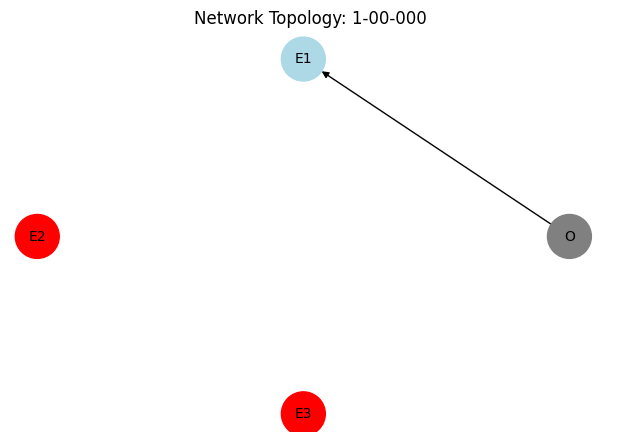

In [290]:
def plot_network_topology(binary_sequence):
    """
    Plot the network topology based on the given binary sequence.

    :param binary_sequence: Binary sequence representing the network topology.
                            Example: "1-10-101-1011-00111"
    """
    # Parse the binary sequence into individual encoder connections
    connections = binary_sequence.split("-")
    num_encoders = len(connections)

    plt.figure(figsize = (6,4))
    # Create a directed graph
    G = nx.DiGraph()

    # Add the input node O
    G.add_node("O", color="gray", label="Input")

    # Track valid and invalid encoders
    valid_encoders = set()
    invalid_encoders = set()

    # Add encoder nodes and connections
    for i, conn in enumerate(connections, start=1):
        encoder = f"E{i}"  # Name of the encoder node
        G.add_node(encoder, color="lightblue", label="Valid Encoder")  # Default to valid

        # Check connections
        is_valid = False
        for j, bit in enumerate(conn):
            if j == 0:  # First bit: connection from input node O
                if bit == "1":
                    G.add_edge("O", encoder)
                    is_valid = True
            else:  # Other bits: connection from encoder E(j)
                if bit == "1":
                    source_encoder = f"E{j}"
                    G.add_edge(source_encoder, encoder)
                    if source_encoder in valid_encoders:
                        is_valid = True

        # Determine if the encoder is valid or invalid
        if is_valid:
            valid_encoders.add(encoder)
        else:
            invalid_encoders.add(encoder)
            G.nodes[encoder]["color"] = "red"  # Mark as invalid
            G.nodes[encoder]["label"] = "Invalid Encoder"

    # Draw the graph
    colors = [G.nodes[node]["color"] for node in G.nodes]
    labels = {node: G.nodes[node]["label"] for node in G.nodes}

    pos = nx.circular_layout(G)  # Layout for visualization
    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=1000, font_size=10, font_color="black")

    # Show the graph

    plt.title(f"Network Topology: {binary_sequence}")
    plt.show()


binary_sequence = "1-00-000"
plot_network_topology(binary_sequence)


Here it is invalid topology

---



#### Ensemble MSE calculation function

In [291]:
def ensemble_esn(binary_sequence):
    '''
       initialise each encoder based on number of inputs
    '''
    # Parse the binary sequence into individual encoder connections
    esn = []  # store the encoders
    connections = binary_sequence.split("-")  # split the sequence
    num_encoders = len(connections)

    for i in range(num_encoders):   # start with each encoder
      num_input = 0
      x = 0 #esn type if 1 esn is connected to only input
      for count, j in enumerate(connections[i]):  # start each possible input connection
        if count == 0 and j == '1':
           num_input = num_input + 1  #only connected to input
        elif j == '1':
           num_input = num_input + 200
        else: num_input = num_input  #connected to other encoder

      if connections[i][0] == '1' and connections[i].count('1') == 1: x = 1  # taken care cases like "100", "010", "001"
      else: x = 0 # if connented other encoders
      esn.append(EchoStateNetwork(200, num_input , input_scale , alpha, x , beta=1e-8)) # initialise
      # print(f"ESN {i} num_input: {num_input}, esn_no: {x}")

    return esn #return the list


Lets test one case

In [292]:
esn = ensemble_esn("1-10-101")

In [293]:
def mse_binary_sequence(binary_sequence):
    connections = binary_sequence.split("-") #split the sequence
    num_encoders = len(connections)

    esn = ensemble_esn(binary_sequence)

    ensemble_activation = []  #store the activation of each state
    test = []                 #store the test result
    esn_future = []           #store future state of each esn
    state = None
    future = None
    for i in range(num_encoders):           # Start with each encoder
        W_in, W = esn[i].generate_weights() # Generate the input and recurrent weights
        W = esn[i].set_spectral_radius(rho) # Scale the spectral radius

        if i == 0 :                         # first ESN has only one possible connection ie from input
            state = data[mg_choice]
            Y_target = esn[i].create_target(data[mg_choice], offset_val) # Generate the target data wrt offset
            X = esn[i].neuron_activations(train_len, state)              # Map input data through reservoir and collect neuron activations
            W_out = esn[i].train_output_weights(Y_target,X, train_len)
            Y_test, ESN_futrue = esn[i].test(X, data[mg_choice], W_out, train_len, test_len, None, mode = "generative") # only initial ESN kept in generative mode

        else:
            for count, j in enumerate(connections[i]):    # start with each possible connection
                if count == 0 and j == '1':               # check it is connected to input or not
                  state = data[mg_choice][:train_len]     # take input in state

                elif j== '1':
                    if state is None:
                      state = ensemble_activation[count-1]  # not connected with input

                    else:
                      if state.ndim == 1:
                         state.reshape(-1,1)        # to make (2000,) to (2000,1)
                         state = state.T
                      state = vstack((state,ensemble_activation[count-1]))  # stack all the state(inputs coming)


                    if future is None:
                      future = esn_future[count-1]
                    else:
                      future = vstack((future,esn_future[count-1]))         #stack all the future_state of the previous connection

            if state.ndim != 1:     # state is one dimentional means only connected to input so need to explicitly add a bias term
              bias = np.ones((1, state.shape[1]))
              state = vstack((bias,state))  #add bias

            if future is not None:
              bias = np.ones((1, future.shape[1]))
              if connections[i][0] == '1' and connections[i].count('1') != 1:  # if only connetion is with input then need to bias explicitly for dimention matching
                  bias1 = np.ones((1, future.shape[1]))
                  future = vstack((bias,bias1,future)).T  #add bias

              else: future = vstack((bias,future)).T

            Y_target = esn[i].create_target(data[mg_choice], offset_val) # Generate the target data wrt offset
            X = esn[i].neuron_activations(train_len, state.T)            # Map input data through reservoir and collect neuron activations
            W_out = esn[i].train_output_weights(Y_target,X, train_len)

            Y_test, ESN_futrue = esn[i].test(X, data[mg_choice], W_out, train_len, test_len, future, mode = "forward") #here each encoder set in forward mode

        # remove the bias as explicitly will be added in next connected encoder
        ensemble_activation.append(X[1:])
        esn_future.append(ESN_futrue[1:])
        test.append(Y_test)

        state = None
        future = None

    net_result = np.zeros((test[0].shape[0],test[1].shape[1]))
    for i in test:
      net_result += i
    return  net_result/num_encoders # return the avg of all output form  all the encodet

Lets take one sample

In [294]:
y = mse_binary_sequence("1-11-111")

In [295]:
#x_lim = 100
x_vals = arange(test_len)

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_vals, y=y[0,0:x_lim],
                         name='test data'))
fig.add_trace(go.Scatter(x=x_vals, y=Y_target_1[0,train_len:train_len+x_lim],
                         name='target data'))

fig.update_layout(title='test output vs target output',
                   xaxis_title='time',
                   yaxis_title='Target value')


fig.show()


In [296]:
#if we want to only compute the error on a portion of the output, we can adjust the data we supply to the mse function
n_points_error = 499
x_lim = n_points_error + 1
print("MSE :", mse(y[:, 0:n_points_error], Y_target_1[0,train_len:train_len+n_points_error]))

MSE : 20.203488172240203


Its shows drastic change in accuracy shows the importance of connection topology

#### Validity checking function

In [297]:

def is_valid_sequence(sequence, num_encoders):

    # Track valid and invalid encoders
    valid_encoders = set()
    invalid_encoders = set()
    connections = sequence.split("-")

    # Add encoder nodes and connections
    for i, conn in enumerate(connections, start=1):
        encoder = f"E{i}"  # Name of the encoder node
        # Check connections
        is_valid = False
        for j, bit in enumerate(conn):
            if j == 0:  # First bit: connection from input node O
                if bit == "1":
                    is_valid = True
            else:  # Other bits: connection from encoder E(j)
                if bit == "1":
                    source_encoder = f"E{j}"
                    if source_encoder in valid_encoders:
                        is_valid = True

        # Determine if the encoder is valid or invalid
        if is_valid:
            valid_encoders.add(encoder)
        else:
            invalid_encoders.add(encoder)
            return False
    return True

#### Unique sequence generating function

In [298]:
def generate_unique_sequences(num_sequences, num_encoders, cases, p = 0.5):
    sequences = set()
    total_bits = sum(range(1, num_encoders + 1))  # Total bits for all encoders

    while len(sequences) < num_sequences:
        # Generate random binary sequence of length total_bits
        binary_string = ''.join(np.random.choice(['0', '1'], size=total_bits, p=[1-p, p]))

        # Split into segments for each encoder
        sequence = []
        start_idx = 0
        for i in range(1, num_encoders + 1):
            sequence.append(binary_string[start_idx:start_idx + i])
            start_idx += i

        # Convert to the required format: "1-10-100"
        formatted_sequence = '-'.join(sequence)

        # Check if the sequence is valid ,unique and not present cases
        if len(cases) == 0:
          if is_valid_sequence(formatted_sequence, num_encoders) and formatted_sequence not in cases:
              sequences.add(formatted_sequence)
        else:
          if is_valid_sequence(formatted_sequence, num_encoders): sequences.add(formatted_sequence)


    return list(sequences)


#### Bit mutation function

In [299]:
def mutate_bit_sequence(bit_sequence, mutation_probability):
    """
    Mutates each bit in a bit sequence with a given mutation probability.

    Parameters:
        bit_sequence (str): The bit sequence in the format "1-10-100".
        mutation_probability (float): The probability of mutating each bit.

    Returns:
        str: The mutated bit sequence.
    """
    segments = bit_sequence.split("-")
    mutated_segments = []

    for segment in segments:
        mutated_segment = ""
        for bit in segment:
            if random.random() < mutation_probability:  # Apply mutation
                mutated_bit = '1' if bit == '0' else '0'  # Flip the bit
            else:
                mutated_bit = bit  # Keep the bit unchanged
            mutated_segment += mutated_bit
        mutated_segments.append(mutated_segment)

    # Rejoin the mutated segments with "-"
    mutated_sequence = "-".join(mutated_segments)

    if is_valid_sequence(mutated_sequence, len(segments)):     #check it the mutation is valid
       return mutated_sequence
    else: return bit_sequence                                  #if not valid return same sequence

#### Genetic Algorithm function

In [300]:
def Genetic_algo(N, NE, pm, cases):
    valid_sequences = generate_unique_sequences(N, NE, cases)
    fg = float('inf')
    Bg = None     #fittest indivisual
    print("Generated Valid Sequences: ",valid_sequences)
    r = 0 #round count

    while len(valid_sequences)>1 :
      r = r+1
      print(f"Genetic Algo round {r}")
      unfitness = []
      #Evaluation
      for i in range(len(valid_sequences)):
          # print(i)
          y = mse_binary_sequence(valid_sequences[i])
          # print(f"training of {valid_sequences[i]} done")
          n_points_error = 499
          x_lim = n_points_error + 1
          unfitness.append(mse(y[:, 0:n_points_error], Y_target_1[0,train_len:train_len+n_points_error]))

      for j in range(len(valid_sequences)):
          if unfitness[j] < fg:
            fg = unfitness[j]
            Bg = valid_sequences[j]

      #Selection
      survival_threat = [] #store the survival threat indivisual sequence
      b = min(unfitness)
      a = max(unfitness)
      for k in range(len(valid_sequences)):
        survive = (unfitness[k] - b)/ (a-b)
        survival_threat.append(survive)

      max_index = survival_threat.index(max(survival_threat))
      # del unfitness[max_index]
      del valid_sequences[max_index] #remove the max survival threat encoder

      #Mutation
      for seq in range(len(valid_sequences)):
         valid_sequences[seq] = mutate_bit_sequence(valid_sequences[seq], pm)

      if Bg not in valid_sequences:
         valid_sequences.append(Bg)

      print(f"sequences: {valid_sequences}")
      print("-"*100)


    return(valid_sequences[0])

In [301]:
# Example usage
N = 10  # Number of unique valid sequences to generate
NE = 3  # Number of encoders
pm = 0.05 # mutation probability
cases = [] #some special cases the want to ommit like '1-10-100','1,01-001','1-11-111' from first initialization
optimal_sequence = Genetic_algo(N, NE, pm, cases)
print('\n')
print("optimal sequence of ensemble ESN", optimal_sequence)



Generated Valid Sequences:  ['1-01-111', '1-10-100', '1-11-001', '1-01-110', '1-10-011', '1-01-010', '1-01-001', '1-11-111', '1-11-010', '1-11-101']
Genetic Algo round 1
sequences: ['1-01-111', '1-10-100', '1-11-001', '1-01-100', '1-10-011', '1-01-010', '1-11-001', '1-11-111', '1-11-101']
----------------------------------------------------------------------------------------------------
Genetic Algo round 2
sequences: ['1-01-011', '1-10-110', '1-11-001', '1-01-100', '1-10-011', '1-01-010', '1-11-001', '1-11-111']
----------------------------------------------------------------------------------------------------
Genetic Algo round 3
sequences: ['1-01-011', '1-10-110', '1-01-100', '1-10-111', '1-01-010', '1-11-001', '1-11-111']
----------------------------------------------------------------------------------------------------
Genetic Algo round 4
sequences: ['1-01-001', '1-01-100', '1-10-111', '1-01-010', '1-11-001', '1-11-111']
--------------------------------------------------------

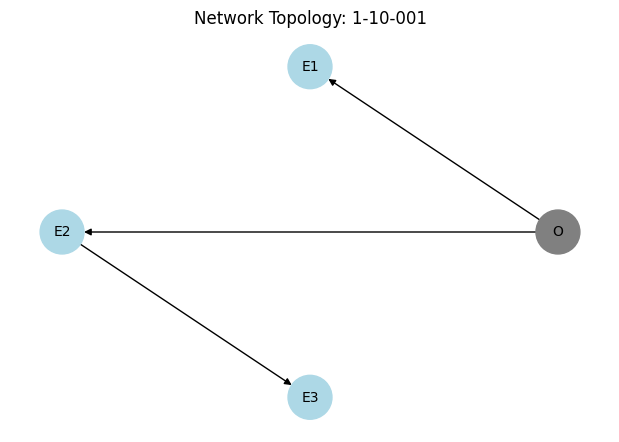



MSE : 0.00024091128042239238


In [302]:
y_optimal = mse_binary_sequence(optimal_sequence)        # get the corresponding testing result
plot_network_topology(optimal_sequence)

#if we want to only compute the error on a portion of the output, we can adjust the data we supply to the mse function
n_points_error = 499
x_lim = n_points_error + 1

print("\n")
print("MSE :", mse(y_optimal[:, 0:n_points_error], Y_target_1[0,train_len:train_len+n_points_error]))

In [303]:
#x_lim = 100
x_vals = arange(test_len)

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_vals, y=y_optimal[0,0:x_lim],
                         name='test data'))
fig.add_trace(go.Scatter(x=x_vals, y=Y_target_1[0,train_len:train_len+x_lim],
                         name='target data'))

fig.update_layout(title='test output vs target output',
                   xaxis_title='time',
                   yaxis_title='Target value')


fig.show()


In [309]:
cases = ['1-10-100','1,01-001','1-11-111'] #some special cases the want to ommit like '1-10-100','1,01-001','1-11-111' from first initialization
optimal_sequence_without_cases = Genetic_algo(N, NE, pm, cases)
print('\n')
print("optimal sequence of ensemble ESN", optimal_sequence_without_cases)


Generated Valid Sequences:  ['1-10-111', '1-11-011', '1-11-110', '1-01-111', '1-10-001', '1-10-011', '1-10-110', '1-10-010', '1-01-101', '1-11-100']
Genetic Algo round 1
sequences: ['1-10-111', '1-11-011', '1-01-111', '1-11-001', '1-10-011', '1-10-110', '1-10-110', '1-01-101', '1-11-100', '1-10-001']
----------------------------------------------------------------------------------------------------
Genetic Algo round 2
sequences: ['1-10-111', '1-11-011', '1-01-111', '1-10-011', '1-10-110', '1-10-110', '1-01-101', '1-11-100', '1-10-001']
----------------------------------------------------------------------------------------------------
Genetic Algo round 3
sequences: ['1-10-111', '1-11-011', '1-01-101', '1-10-011', '1-10-110', '1-01-101', '1-11-100', '1-10-001']
----------------------------------------------------------------------------------------------------
Genetic Algo round 4
sequences: ['1-10-111', '1-11-011', '1-01-101', '1-10-011', '1-10-010', '1-01-101', '1-10-001']
--------

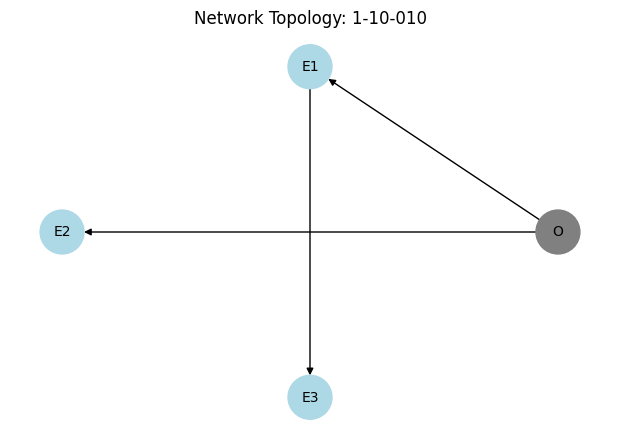



MSE : 0.0001306850161082913


In [310]:
y_optimal = mse_binary_sequence(optimal_sequence_without_cases)        # get the corresponding testing result
plot_network_topology(optimal_sequence_without_cases)

#if we want to only compute the error on a portion of the output, we can adjust the data we supply to the mse function
n_points_error = 499
x_lim = n_points_error + 1
print("\n")
print("MSE :", mse(y_optimal[:, 0:n_points_error], Y_target_1[0,train_len:train_len+n_points_error]))

In [306]:
#x_lim = 100
x_vals = arange(test_len)

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_vals, y=y_optimal[0,0:x_lim],
                         name='test data'))
fig.add_trace(go.Scatter(x=x_vals, y=Y_target_1[0,train_len:train_len+x_lim],
                         name='target data'))

fig.update_layout(title='test output vs target output',
                   xaxis_title='time',
                   yaxis_title='Target value')


fig.show()


Here as running genetic algorithm without speacial cases give better result than with special cases

And in this two case got different optimal connection


*   inculding special connection : 1-10-001
*   excluding special connection : 1-10-010

Both case giving better results than 1-01-001 (series connection), 1-10-100 (parallel connection), 1-11-111 (cross connection) and single esn



### References


1.   https://github.com/tguidici/ODSC_2020_ESN/blob/master/ESN_tutorial.ipynb
2.   Z. Li, K. Fujiwara and G. Tanaka, "Designing Network Topologies of Multiple Reservoir Echo State Networks: A Genetic Algorithm Based Approach," 2024 International Joint Conference on Neural Networks (IJCNN), Yokohama, Japan, 2024, pp. 1-9, doi: 10.1109/IJCNN60899.2024.10650945


